#Lab.10 / IBM3202 – Conformational changes using Structure-Based Models

###Theoretical aspects

The **energy landscape theory** and the **principle of minimum frustration** in protein folding have provided the theoretical basis for the generation of simplified models to simulate the pathways of protein folding of different proteins. Noteworthy, recent work has demonstrated their utility for simulating other functionally relevant phenomena, such as **protein misfolding and conformational changes** associated to biological function. Most of these applications have been generated through savvy and careful combinations of the native bonded and non-bonded terms from **two or more structures deposited in the PDB** in two or more conformational states (i.e. open and closed conformations, alpha and beta states, etc).

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/smogdual_01.png'/>
<figcaption>FIGURE 1. Modeling the conformational transitions of adenylate kinase. This enzyme undergoes a >25 Å motion between open (red, PDB 4AKE) and closed (green, PDB 1AKE) states due to ligand binding. The relative occupation of the closed and open states can be tuned to experimental data by varying the strength of the subset of contacts only existing in the closed state between 0.6 (red) to 1.2 (black) relative to the open contacts <br> Noel JK & Onuchic JN (2012) <i> Computational Modeling of Biological Systems, 31-54</i></figcaption></center>
</figure>

##Experimental Overview

In this tutorial we will exemplify how we can **combine the native contacts of two different structures** to simulate the conformational change of adenylate kinase, an enzyme that has three domains (LID, NMP and core) and catalyzes the phosphorylation reaction of AMP, using ATP, generating 2 molecules of ADP as product:

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/smogdual_02.png'/>
</center>
</figure>

This reaction requires a severe conformational change, which can be seen from the structures of the protein in the presence (1AKE) and in the absence (4AKE) of substrates.

#Part 0. Downloading and Installing the required software

Before we start, **remember to start the hosted runtime** in Google Colab.

Then, we must install several pieces of software to perform this tutorial. Namely:
- **biopython** for manipulation of the PDB files
- **py3Dmol** for visualization of the protein structure.
- **udocker** for installing and running Docker containers
- **SMOG2** for generating our structure-based models
- **SBM-enhanced GROMACS** for preparing our MD system and performing our MD simulations.

For visualizing our MD trajectories, we will employ a web version of **NGLview**. This is due to the inability of Google Colab to handle a required python package for loading NGLview directly onto Google Colab. Hopefully this will change in the near future.

1. First, we will start by installing **udocker** to pull and run a Docker version of **SMOG2** onto Google Colab.

In [1]:
#Downloading udocker and installing smog2
!pip install udocker
!udocker --allow-root install
!udocker --allow-root pull smogserver/smog2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 2.9 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.12
Info: searching for udockertools >= 1.2.10
Info: installing udockertools 1.2.10
Info: installation of udockertools successful
Info: downloading layer sha256:43954e79bb981f7d7462a686e18204e0037540a45fc352aa28bd276608294508
Info: downloading layer sha256:22a2ce8aadd46b1628732e7f15f94ab0ed8f7a9d0fd1612640483613737f6f3a
Info: downloading layer sha256:48ba6d8268181f8e9a8655ebc240d7fc2c1754aea839220076034f89d24130c7
Info: downloading layer sha256:321cee23bc24a9bfd33094ef0b895d4ba7e6720f1ad86c07898bf6124b44c3ed
Info: downloading layer sha256:d9d12fd0ad47bc596cac438495774418cff9dca4745152d770b13b137624068f
Info: downloading layer sha256:3d2864a338ae73c8a7663754e95cd117dac31eecc3e4664f6859eb1119cc826a
Info: downloading layer sha256:8677fae59baf9f86dc84297813429d3e29296d5d3865b61a58e8fcb7b14ca683
Info: downloading layer sha256:4f4fb700e

In [2]:
#Test the smog2 docker installation
!udocker --allow-root run --rm -v $(pwd):/workdir smogserver/smog2:stable smog2 --help

Info: downloading layer sha256:43954e79bb981f7d7462a686e18204e0037540a45fc352aa28bd276608294508
Info: downloading layer sha256:22a2ce8aadd46b1628732e7f15f94ab0ed8f7a9d0fd1612640483613737f6f3a
Info: downloading layer sha256:48ba6d8268181f8e9a8655ebc240d7fc2c1754aea839220076034f89d24130c7
Info: downloading layer sha256:321cee23bc24a9bfd33094ef0b895d4ba7e6720f1ad86c07898bf6124b44c3ed
Info: downloading layer sha256:d9d12fd0ad47bc596cac438495774418cff9dca4745152d770b13b137624068f
Info: downloading layer sha256:3d2864a338ae73c8a7663754e95cd117dac31eecc3e4664f6859eb1119cc826a
Info: downloading layer sha256:8677fae59baf9f86dc84297813429d3e29296d5d3865b61a58e8fcb7b14ca683
Info: downloading layer sha256:4f4fb700ef54461cfa02571ae0db9a0dc1e0cdb5577484a6d75e68dc38e8acc1
Info: downloading layer sha256:56eceda4ebdb701e4355bf76bff8f22369deaa7c6d108cf36e991f1276d3a092
Info: downloading layer sha256:092d29570c961c160b81180b04c11e64f443e00fd66d529e231ceaffb829803b
Info: downloading layer sha256:dbf6a9bef

2. Then, we will set up our SBM-enhanced GROMACS on Google Colab, based on your previously compiled and installed GROMACS

In [3]:
# Download and unzip the compressed folder of SBM-enhanced GROMACS
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs_sbm.tar.gz
!tar xzf gromacs_sbm.tar.gz

--2023-11-02 18:03:46--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs_sbm.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23608271 (23M) [application/octet-stream]
Saving to: ‘gromacs_sbm.tar.gz’

gromacs_sbm.tar.gz  100%[===================>]  22.51M  --.-KB/s    in 0.06s   

2023-11-02 18:03:46 (359 MB/s) - ‘gromacs_sbm.tar.gz’ saved [23608271/23608271]



3. Lastly, we will install biopython and py3Dmol

In [4]:
!pip install biopython py3dmol

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.1 MB/s eta 0:00:00


Once these software installation processes are completed, we are ready to perform our experiments

# Part I – Generate coarse-grained SBM models using SMOG2

As we did in the previous tutorial, we will first download the coordinates for the solved structures of human adenylate kinase in the open (4AKE) and closed (1AKE) states to generate coarse-grained SBMs for both structures using SMOG2. Then, we will employ a combination of numerical analysis and SMOG2 to generate custom-built SBM models that contain information from both structures in a single file (**dual-basin models**).

1. We start by creating and accessing a folder for preparing our systems

In [5]:
#Let's make a folder first. We need to import the os and path library
import os
from pathlib import Path

#Then, we define the path of the folder we want to create.
#Notice that the HOME folder for a hosted runtime in colab is /content/
smogpath = Path("/content/prepare_dualAKE/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(smogpath):
  print("path already exists")
if not os.path.exists(smogpath):
  os.mkdir(smogpath)
  print("path was succesfully created")

path was succesfully created


In [6]:
#Changing directory using python
os.chdir(smogpath)

2. Then, we will download the solved structures of human adenylate kinase in the open (PDB 4AKE) and closed (PDB 1AKE) conformations, and remove alternative side chain conformations, water molecules and ligands using biopython as we have done in our previous tutorials.

**NOTE:** You might get a _chain discontinuity_ warning on biopython. In this particular case, this is due to the non-contiguous annotation of non-protein atoms from chain A and B in the PDB file.

In [7]:
#Importing your PDB file using biopython
import os
from Bio.PDB import *
pdbid = ['1ake', '4ake']
pdbl = PDBList()
for s in pdbid:
  pdbl.retrieve_pdb_file(s, pdir='.', file_format ="pdb", overwrite=True)
  os.rename("pdb"+s+".ent", s+".pdb")

In [8]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()

#And here we set the residue conformation we want to keep
keepAltID = "A"
class KeepOneConfOnly(Select):  # Inherit methods from Select class
    def accept_atom(self, atom):
        if (not atom.is_disordered()) or atom.get_altloc() == keepAltID:
            atom.set_altloc(" ")  # Eliminate alt location ID before output.
            return True
        else:  # Alt location was not one to be output.
            return False
        # end of accept_atom()

#And now we loop for all structures
for s in pdbid:
  structure = parser.get_structure('X', s+".pdb")
  #This will keep only conformation for each residue
  io.set_structure(structure)
  io.save(s+"_ready.pdb", select=KeepOneConfOnly())
print("Your PDBs were processed. Alternative side chain conformations removed!")

/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3796.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3860.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3917.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 4158.
  warnings.warn(


Your PDBs were processed. Alternative side chain conformations removed!


/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 3686.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 3758.
  warnings.warn(


In [9]:
#Here we set up a parser for our PDB
parser = PDBParser()
io=PDBIO()
for s in pdbid:
  structure = parser.get_structure('X', s+"_ready.pdb")
  #And here we remove hydrogens, waters and ligands using Dice
  io.set_structure(structure)
  sel = Dice.ChainSelector('A', 1, 214)
  io.save(s+"_clean.txt", sel)
print("Your PDBs were processed. Only the protein heavy atoms have been kept!")
print("Both PDBs have been saved as text files for editing on Google Colab")
print("Remember to edit them before using SMOG2")

Your PDBs were processed. Only the protein heavy atoms have been kept!
Both PDBs have been saved as text files for editing on Google Colab
Remember to edit them before using SMOG2


3. Let's examine our structures in py3Dmol

In [10]:
import py3Dmol
#First we assign the py3Dmol.view as a two-panel viewer
view=py3Dmol.view(800,400)
#Here we set the background color as white
view.setBackgroundColor('white')
#The following lines are used to add the addModel class
#to read the open state structure
view.addModel(open('4ake_clean.txt', 'r').read(),'pdb')
#Here we set the visualization style and color
view.setStyle({'chain':'A'},{'cartoon': {'color':'red'}})
#Here we center the molecule for its visualization
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
import py3Dmol
#First we assign the py3Dmol.view as a two-panel viewer
view=py3Dmol.view(800,400)
#Here we set the background color as white
view.setBackgroundColor('white')
#Now we do the same for the closed state structure
view.addModel(open('1ake_clean.txt', 'r').read(),'pdb')
#Here we set the visualization style and color
view.setStyle({'chain':'A'},{'cartoon': {'color':'green'}})
#Here we center the molecule for its visualization
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

4. As we saw in our previous tutorial, these PDB files are saved as .txt files to edit the, based on the format requirements of SMOG2. **Fix both files accordingly!**

5. Once this is done, we can process our files in SMOG2 as indicated below:

In [12]:
!udocker --allow-root run --rm -v $(pwd):/workdir smogserver/smog2:stable smog2 -i 4ake_clean.txt -CA -dname 4ake_smog
!udocker --allow-root run --rm -v $(pwd):/workdir smogserver/smog2:stable smog2 -i 1ake_clean.txt -CA -dname 1ake_smog

 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING 0ce615f9-9d33-39ac-8c66-360404e91619                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: smog2
*******************************************************************************************

******* ******* ******* ******* ******* SMOG v2.4.5 ******* ******* ******* ******* *******
                                             
               Thank you for using the Structure-based Model (SMOG) software
                                             
     This package is the product of contributions from a number of people, including:
            Jeffrey Noel, Mariana Levi, Antonio Oliveira, Vinícius Contessoto,
          Esteban Dodero-Rojas, Mohit Raghunathan, Joyce

#Part II – Generate a custom dual-basin SBM model using SMOG2

We should now have our SBM models for the open and the closed state of human adenylate kinase. However, if you remember from our lectures and our previous tutorial, these coarse-grained models do not contain water molecules, ligands, etc. Moreover, since we do not have water in our system, the inclusion of a ligand will lead to its drift outside the active site towards infinity (as you can see from the .mdp simulation file, we are not using periodic boundary conditions).

**How are we going to simulate a conformational change in the absence of ligands?**

Instead of thinking of including the ligand, we must think about the **consequences of ligand binding**. In this case, ligand binding leads to the three domains of the protein getting closer to each other, which translates into **several native contacts being formed upon ligand binding** (or unique to the closed conformation).

Briefly, to simulate the conformational change of this enzyme, it is most appropriate to consider that:
- The **open state** is the **initial condition**, since it can exist both in the absence of and at low concentrations of ligand;
- The native interactions that are **unique to the closed state** correspond to **ligand-induced interactions**;
- The **native ligand-induced interactions** that exhibit significant changes in distance (eg. dist [4AKE] / dist [1AKE] > 50%) are **the only ones to be included in a combined native contact map** (or dual-basin potential).

This is, in fact, shown in the following figure from an article that inspired this tutorial

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/smogdual_03.jpg'/>
<figcaption>FIGURE 2. Plot of the contacts unique to the closed form of adenylate kinase. Each point represents a contact between residue <i>i</i> and residue <i>j</i> that is unique to the closed form. The Y-axis is the distance between the C${\alpha}$ atoms of residues <i>i</i> and <i>j</i> in the open form and the X-axis is the distance in the closed form. Contacts above the line of slope 1.5 (solid line) constitute the set of contacts selected for the dual-basin SBM models<br> Whitford PC et al (2007) <i> J Mol Biol 366(5), 1661-1671</i></figcaption></center>
</figure>

1. **How can we first filter the contacts that are unique to the closed conformation?** We will use `grep` over the **.contact.CG files** you just obtained during the SMOG2 processing for the open and closed states:

In [13]:
#Creating a folder for preparing the dual-basin SBM model
dualpath = Path("dualSBM")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(dualpath):
  print("path already exists")
if not os.path.exists(dualpath):
  os.mkdir(dualpath)
  print("path was succesfully created")

#Switching to this new folder
os.chdir(dualpath)

path was succesfully created


In [14]:
#Using grep to check which lines in file1 (4ake) are also in file2 (1ake)
#The -v flag inverts the sence of matching, thus printing non-matching lines from file2
!grep -Fxvf ../4ake_smog.contacts.CG ../1ake_smog.contacts.CG > uniquecontacts.txt

If all goes well, you should obtain a list of 113 contacts in the format `chain_i res_i chain_j res_j`. Now, we have to evaluate if the distance of these contacts is significantly different between the open and closed states.

2. To determine the distance difference between these contacts in the open and closed states, we will cheat a little bit. We will first use the `trjconv` module from GROMACS to generate a **coarse-grained PDB file** of both states based in our coarse-grained SBM .gro file. Then, we will use SMOG2, along with these coarse-grained PDB files and our list of unique contacts for the closed structure. With this small trick, we will obtain the **LJ parameters (and therefore the distances!)** of the ligand-induced contacts both in the open (4AKE) and closed (1AKE) states.

In [15]:
#Generating coarse-grained PDB for 4AKE and 1AKE using GROMACS
%%bash
source /content/gromacs_sbm/bin/GMXRC
gmx editconf -f ../4ake_smog.gro -o 4ake_CA.pdb
gmx editconf -f ../1ake_smog.gro -o 1ake_CA.pdb
#Edit your file to comply with SMOG2 parameters
grep ATOM 4ake_CA.pdb > 4ake_CA_clean.pdb
echo "END" >> 4ake_CA_clean.pdb
grep ATOM 1ake_CA.pdb > 1ake_CA_clean.pdb
echo "END" >> 1ake_CA_clean.pdb

Read 214 atoms
Volume: 259.568 nm^3, corresponds to roughly 116800 electrons
No velocities found
Read 214 atoms
Volume: 200.737 nm^3, corresponds to roughly 90300 electrons
No velocities found


GROMACS:    gmx editconf, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or

In [25]:
!udocker --allow-root run --rm -v $(pwd):/workdir smogserver/smog2:stable smog2 -i 4ake_CA_clean.pdb -c uniquecontacts.txt -t /opt/smog2/SBM_calpha -dname 4ake_unique
!udocker --allow-root run --rm -v $(pwd):/workdir smogserver/smog2:stable smog2 -i 1ake_CA_clean.pdb -c uniquecontacts.txt -t /opt/smog2/SBM_calpha -dname 1ake_unique

 
 ****************************************************************************** 
 *                                                                            * 
 *               STARTING bffbef36-7a85-3bba-9717-047267d71411                * 
 *                                                                            * 
 ****************************************************************************** 
 executing: smog2
*******************************************************************************************

******* ******* ******* ******* ******* SMOG v2.4.5 ******* ******* ******* ******* *******
                                             
               Thank you for using the Structure-based Model (SMOG) software
                                             
     This package is the product of contributions from a number of people, including:
            Jeffrey Noel, Mariana Levi, Antonio Oliveira, Vinícius Contessoto,
          Esteban Dodero-Rojas, Mohit Raghunathan, Joyce

If we remember from our previous tutorial, the `[ pairs ]` section of the .top file contains the native contacts and their parameters.

<figure>
<center>
<img src='https://raw.githubusercontent.com/pb3lab/ibm3202/master/images/smogdual_05.png'/>
</center>
</figure>

Since we requested the same user-defined contact map for both files in the previous step, we can get the difference in distance between each contact by **dividing column 4 (or 5) from one file by the column 4 (or 5) from another file**

3. Create two text files on Google Colab in which you will store only the `[ pairs ]` section of these newly generated .top files. Then, we will use `awk` over these files to determine which interactions significantly change between these states:

In [26]:
#Creating two files only containing the pairs sections using awk
#And eliminating first and last printed lines using sed
!awk 'NR==1, $2 == "pairs" {next}; NF {print $0}; $2 == "exclusions" {exit}' 1ake_unique.top | sed '1d;$d' > closed.pairs
!awk 'NR==1, $2 == "pairs" {next}; NF {print $0}; $2 == "exclusions" {exit}' 4ake_unique.top | sed '1d;$d' > open.pairs

In [27]:
!paste open.pairs closed.pairs | awk '{if(($4/$9)>1.5)print $1, $2, $3, $9, $10}' > Qligand.pairs

After this, we will obtain a text file with **83 contacts** that are unique to the closed state for which a significant change in distance (>50%) occurs upon reaching the unbound, open conformation.

4. We will also use `awk` to generate the `[ exclusion ]` lists for these ligand-induced native contacts.


In [28]:
!paste open.pairs closed.pairs | awk '{if(($4/$9)>1.5)print $1, $2}' > Qligand.exclusions

Now we have everything we need to generate a dual-basin model for simulating the conformational change of human adenylate kinase: coordinate and parameter files and ligand-induced native contacts.

5. We will take one of the .top files for one of the states of human adenylate kinase and manually add the ligand-induced pairs and exclusions that we just obtained. Given our previous assumption on the conformational change of this protein, **the most reasonable strategy is to use the .top file from the open (4AKE) structure for its modification.**

In [29]:
#Copy the .top file for 4AKE into this folder and modify it!
!cp ../4ake_smog.top dualAKE.top

#Part III – Run and analyze our dual-basin SBM simulations

Now, we are ready to perform our simulations of the ligand-induced conformational change of human adenylate kinase using these dual-basin SBM models.

1. We will start by creating a new folder for preparing and running our MD simulations, in which we will copy our SBM coordinate and topology file.

In [30]:
#Defining a new folder for the MD simulations
mdpath = Path("/content/md_dualAKE/")

#Now, we create the folder using the os.mkdir() command
#The if conditional is just to check whether the folder already exists
#In which case, python returns an error
if os.path.exists(mdpath):
  print("path already exists")
if not os.path.exists(mdpath):
  os.mkdir(mdpath)
  print("path was succesfully created")

path was succesfully created


In [31]:
#Changing to our newly created directory and copying the .gro and .top files
os.chdir(mdpath)
from shutil import copyfile
copyfile(smogpath/'4ake_smog.gro', mdpath/'dualAKE.gro')
copyfile(smogpath/dualpath/'dualAKE.top', mdpath/'dualAKE.top')

PosixPath('/content/md_dualAKE/dualAKE.top')

2. Then, we will download the same **MD instruction file** that we used in our previous tutorial (**mdrun_CA_v5.mdp**), changing the simulation temperature to 108 and the number of steps to 5000000. We will also download the Perl script to generate our LJ 12-10 tabulated potentials.

In [32]:
%%bash
wget https://github.com/pb3lab/ibm3202/raw/master/files/mdrun_CA_v5.mdp
wget https://github.com/pb3lab/ibm3202/raw/master/files/maketable4.pl
perl maketable4.pl > table.xvg

--2023-11-02 18:37:01--  https://github.com/pb3lab/ibm3202/raw/master/files/mdrun_CA_v5.mdp
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/mdrun_CA_v5.mdp [following]
--2023-11-02 18:37:01--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/mdrun_CA_v5.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3238 (3.2K) [text/plain]
Saving to: ‘mdrun_CA_v5.mdp’

     0K ...                                                   100% 29.3M=0s

2023-11-02 18:37:01 (29.3 MB/s) - ‘mdrun_CA_v5.mdp’ saved [3238/3238]

--2023-11-02 18:37:01--  https://github.com/pb3lab/i

3. Lastly, we will prepare our **.tpr portable binary run input file for GROMACS** in this folder and run our simulation! Please note how we instruct GROMACS to use our custom table of LJ 12-10 tabulated potentials.

This simulation takes ~15 min.

In [42]:
#Preparing our binary run input file
%%bash
source /content/gromacs_sbm/bin/GMXRC
gmx grompp -f mdrun_CA_v5.mdp -c dualAKE.gro -p dualAKE.top -o run.tpr

Analysing residue names:
There are:   213    Protein residues
There are:     1      Other residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
This run will generate roughly 2 Mb of data


GROMACS:    gmx grompp, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or m

In [43]:
#Running our simulation
%%time
%%bash
source /content/gromacs_sbm/bin/GMXRC
gmx mdrun -s run.tpr -table table.xvg -tablep table.xvg -nt 2 -noddcheck

Process is interrupted.
CPU times: user 2.93 s, sys: 341 ms, total: 3.27 s
Wall time: 10min 46s


4. Once our simulation is done, we can analyze if the conformational change is observed in our trajectory file. For simplification, we will first use the `rmsd` module along with the initial, open structure, as evidence of this change.

In [44]:
%%bash
source /content/gromacs_sbm/bin/GMXRC
#Commands for RMSD
echo "0" > options
echo " " >> options
echo "0" >> options
echo " " >> options
#RMSD calculation
gmx rms -s dualAKE.gro -f traj_comp.xtc -xvg none < options


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 0: 'System'
Selected 0: 'System'


GROMACS:    gmx rms, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modi

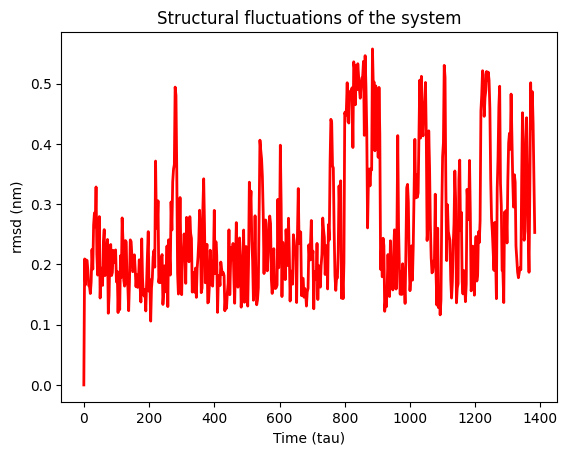

In [45]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('rmsd.xvg')

plt.title('Structural fluctuations of the system')
plt.xlabel('Time (tau)')
plt.ylabel('rmsd (nm)')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red')
plt.show()

2. A better metric for looking at the conformational change would be to directly determine if the ligand-induced native contacts are formed. For this, we will use the `g_kuh` module again, along with the list of contacts that are unique to the closed structure and the closed structure as reference for the native distances. Please check how we are generating the contact map file required for this analysis:

In [51]:
#Generating the contact map file for g_kuh
f = open(mdpath/"Qligand.ndx", "a")
f.write("[ Qligand ]\n")
with open(smogpath/dualpath/"Qligand.exclusions") as infile:
  for line in infile:
    if line.strip():
      cols = line.split()
      f.write(cols[0] + "\t" + cols[1] + "\n")
f.close()

#Copying the reference structure of the closed state for determining native distances
copyfile(smogpath/'1ake_smog.gro', mdpath/'1ake_smog.gro')

PosixPath('/content/md_dualAKE/1ake_smog.gro')

In [52]:
#Analyzing the formation of ligand-induced contacts in our trajectory
%%bash
source /content/gromacs_sbm/bin/GMXRC
g_kuh -s 1ake_smog.gro -f traj_comp.xtc -n Qligand.ndx -noabscut -noshortcut -cut 0.2

GROMACS:    gmx kuh, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or modi

4. Let's plot our results and see what happened during our simulation! We will plot first the change in native contacts (Q), and then the change in potential energy. You can check the change in RMSD yourself

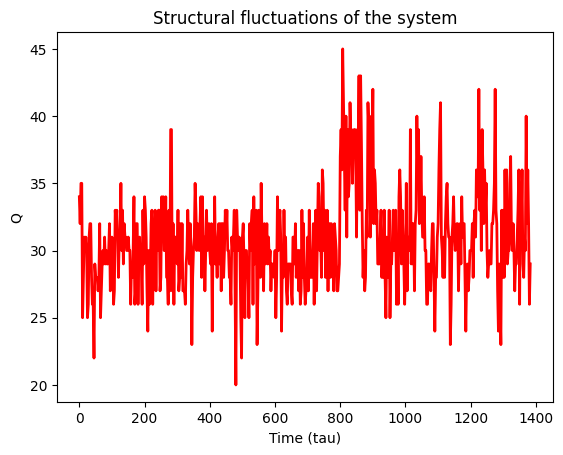

In [53]:
!paste rmsd.xvg qvals.out > data.txt
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('data.txt')

plt.title('Structural fluctuations of the system')
plt.xlabel('Time (tau)')
plt.ylabel('Q')
plt.plot(data[:,0], data[:,2], linestyle='solid', linewidth='2', color='red')
plt.show()

5. To finalize, we will visualize our simulation. For this, we will use the `trjconv` module to extract only the protein from our system and convert our trajectory into a PDB file and then  download this new PDB file and load it onto [**NGLviewer**](http://nglviewer.org/ngl/) as a **trajectory** PDB file.

In [54]:
%%bash
source /content/gromacs_sbm/bin/GMXRC
#This is a trick to provide interactive options to gmx
echo "Protein" > options
echo "Protein" >> options
echo " "
gmx trjconv -s run.tpr -f traj_comp.xtc -o traj.pdb < options

 
Select group for output
Selected 1: 'Protein'


GROMACS:    gmx trjconv, VERSION 5.0.4

GROMACS is written by:
Emile Apol         Rossen Apostolov   Herman J.C. Berendsen Par Bjelkmar       
Aldert van Buuren  Rudi van Drunen    Anton Feenstra     Sebastian Fritsch  
Gerrit Groenhof    Christoph Junghans Peter Kasson       Carsten Kutzner    
Per Larsson        Justin A. Lemkul   Magnus Lundborg    Pieter Meulenhoff  
Erik Marklund      Teemu Murtola      Szilard Pall       Sander Pronk       
Roland Schulz      Alexey Shvetsov    Michael Shirts     Alfons Sijbers     
Peter Tieleman     Christian Wennberg Maarten Wolf       
and the project leaders:
Mark Abraham, Berk Hess, Erik Lindahl, and David van der Spoel

Copyright (c) 1991-2000, University of Groningen, The Netherlands.
Copyright (c) 2001-2014, The GROMACS development team at
Uppsala University, Stockholm University and
the Royal Institute of Technology, Sweden.
check out http://www.gromacs.org for more information.

GROMACS is free software; you can redistribute it and/or 

In [55]:
#Downloading the trajectory PDB file
from google.colab import files
files.download("/content/md_dualAKE/traj.pdb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**And this is the end of the tenth tutorial!** Good science!